In [1]:
import pandas as pd
import json
import os

## 1. Intro to the dataset

First 110 are verified

In [4]:
def read_all_examples(dataset_path='data/text2zinc/train', max_example=None):
    """
    Lee todos los ejemplos del dataset TEXT2ZINC/train hasta un máximo especificado
    
    Args:
        dataset_path (str): Ruta al directorio del dataset
        max_example (int, optional): Número máximo de ejemplo a leer. Si es None, lee todos.
        
    Returns:
        dict: Diccionario con información de todos los ejemplos
    """
    examples = {}
    
    # Verificar que el directorio existe
    if not os.path.exists(dataset_path):
        print(f"Error: El directorio {dataset_path} no existe")
        return examples
    
    # Recorrer todos los subdirectorios
    for item in os.listdir(dataset_path):
        example_path = os.path.join(dataset_path, item)
        
        # Verificar que es un directorio y tiene el formato example_X
        if os.path.isdir(example_path) and item.startswith('example_'):
            example_num = int(item.split('_')[1])
            
            # Verificar si el ejemplo está dentro del límite máximo
            if max_example is not None and example_num >= max_example:
                continue
            
            # Leer archivos del ejemplo
            example_data = {}
            
            # Leer input.json si existe
            input_file = os.path.join(example_path, 'input.json')
            if os.path.exists(input_file):
                try:
                    with open(input_file, 'r', encoding='utf-8') as f:
                        example_data['input'] = json.load(f)
                except Exception as e:
                    print(f"Error leyendo input.json en {item}: {e}")
            
            # Leer output.json si existe
            output_file = os.path.join(example_path, 'output.json')
            if os.path.exists(output_file):
                try:
                    with open(output_file, 'r', encoding='utf-8') as f:
                        example_data['output'] = json.load(f)
                except Exception as e:
                    print(f"Error leyendo output.json en {item}: {e}")
            
            # Leer model.mzn si existe
            model_file = os.path.join(example_path, 'model.mzn')
            if os.path.exists(model_file):
                try:
                    with open(model_file, 'r', encoding='utf-8') as f:
                        example_data['model'] = f.read()
                except Exception as e:
                    print(f"Error leyendo model.mzn en {item}: {e}")
            
            # Leer data.dzn si existe
            data_file = os.path.join(example_path, 'data.dzn')
            if os.path.exists(data_file):
                try:
                    with open(data_file, 'r', encoding='utf-8') as f:
                        example_data['data'] = f.read()
                except Exception as e:
                    print(f"Error leyendo data.dzn en {item}: {e}")
            
            examples[str(example_num)] = example_data
    
    print(f"Se leyeron {len(examples)} ejemplos del dataset")
    return examples


In [5]:
all_examples = read_all_examples(max_example=100)

# Contar y mostrar todos los dominios únicos
domains = set()
domain_counts = {}

for example_num, data in all_examples.items():
    if 'input' in data:
        metadata = data['input'].get('metadata', {})
        domain = metadata.get('domain', 'N/A')
        domains.add(domain)
        domain_counts[domain] = domain_counts.get(domain, 0) + 1

print(f"\nResumen de dominios encontrados en {len(all_examples)} ejemplos:")
print("=" * 50)
for domain in sorted(domains):
    count = domain_counts[domain]
    percentage = (count / len(all_examples)) * 100
    print(f"{domain}: {count} ejemplos ({percentage:.1f}%)")

print(f"\nTotal de dominios únicos: {len(domains)}")
print(f"Total de ejemplos analizados: {len(all_examples)}")

# Mostrar algunos ejemplos de cada dominio
print(f"\nEjemplos por dominio:")
print("=" * 50)
for domain in sorted(domains):
    print(f"\n{domain}:")
    domain_examples = []
    for example_num, data in all_examples.items():
        if 'input' in data:
            metadata = data['input'].get('metadata', {})
            if metadata.get('domain') == domain:
                domain_examples.append((example_num, metadata.get('name', 'N/A')))
    
    # Mostrar hasta 3 ejemplos por dominio
    for example_num, name in domain_examples[:3]:
        print(f"  - Ejemplo {example_num}: {name}")
    if len(domain_examples) > 3:
        print(f"  ... y {len(domain_examples) - 3} más")

Se leyeron 100 ejemplos del dataset

Resumen de dominios encontrados en 100 ejemplos:
Economic and Business Decisions: 10 ejemplos (10.0%)
Energy and Natural Resources: 7 ejemplos (7.0%)
Finance and Investment: 5 ejemplos (5.0%)
Healthcare and Human Systems: 5 ejemplos (5.0%)
Industrial Engineering and Design: 3 ejemplos (3.0%)
Manufacturing and Production: 20 ejemplos (20.0%)
Mathematical Modeling: 13 ejemplos (13.0%)
Network and Security: 2 ejemplos (2.0%)
Puzzles and Games: 8 ejemplos (8.0%)
Scheduling: 14 ejemplos (14.0%)
Transportation and Logistics: 13 ejemplos (13.0%)

Total de dominios únicos: 11
Total de ejemplos analizados: 100

Ejemplos por dominio:

Economic and Business Decisions:
  - Ejemplo 60: Minimize Shopping Cost
  - Ejemplo 61: Department City Assignment
  - Ejemplo 19: Economic Production Planning
  ... y 7 más

Energy and Natural Resources:
  - Ejemplo 1: Road Illumination Optimization
  - Ejemplo 34: Rocket Thrust Optimization
  - Ejemplo 66: Mine Operation Optim

## 2. Agent Construction

We aim to build an agent that can:

1. Given a problem description in natural language (we asume its a full description. i.e: no missing data for the formulation [1]) and the format of the expected outputs
1b. Categorize the problem into a specific domain and call the expert agent for that.
2. Breakdown the problem into a mathematical formulation (i.e: latex or pseudocode expression of the problem)
3. Formulate optimization code using OR-Tools
4. Analyze code integrity using heuristics and tools
5. Call a critique agent to improve the code (Nice to have)
6. Run the code in a sandbox, save the model code, and the outputs.
7. Verify the outputs for correctness

In [6]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from pydantic import BaseModel, Field
import os
import getpass
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END


In [ ]:
load_dotenv()
api_key = ""
if not api_key:
    print(api_key)
    raise ValueError("No openai api key")


In [8]:
llm = ChatOpenAI(model="o3-mini-2025-01-31", api_key=api_key)

In [9]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import ast
import subprocess
import tempfile
import os
import re

# Define the state for the workflow
class State(TypedDict):
    problem_statement: str  # Input problem statement
    problem_name: str  # User-defined problem name
    expected_output: str
    
    math_result: str
    code_result: str
    code_feedback: str
    validation_result: str
    execution_result: str
    execution_error: bool = False
    reflection_status: str
    coherent: bool = True
    last_failure_reason: str

    global_retries: int = 0
    model_saved: bool  # Track if model was successfully saved

### 2.1 - Tools

In [10]:
# Tool: code_validator (validates the generated code)
@tool
def code_validator(code: str) -> str:
    """Validates Python code for syntax errors and basic issues."""
    try:
        # Extract code from markdown if present
        if "```python" in code:
            code = code.split("```python")[1].split("```")[0].strip()
        elif "```" in code:
            code = code.split("```")[1].split("```")[0].strip()
        
        # Parse the code to check for syntax errors
        ast.parse(code)
        
        # Basic checks
        if (
            ("import ortools" not in code and "from ortools" not in code) and
            ("import pulp" not in code and "from pulp" not in code)
        ):
            return "ERROR: Code must import either OR-Tools or PuLP library"
        
        if "def main()" not in code and "if __name__" not in code:
            return "WARNING: Code should have a main function or proper entry point"
        
        return "VALID: Code passed basic validation checks"
        
    except SyntaxError as e:
        return f"ERROR: Syntax error - {str(e)}"
    except Exception as e:
        return f"ERROR: Validation error - {str(e)}"

# Tool: code_executor (executes code in sandbox)
@tool
def code_executor(code: str) -> str:
    """Executes Python code in a sandbox environment and returns the output."""
    try:
        # Extract code from markdown if present
        if "```python" in code:
            code = code.split("```python")[1].split("```")[0].strip()
        elif "```" in code:
            code = code.split("```")[1].split("```")[0].strip()
        
        #print("Code to execute:\n\n", code, "\n", "--"*60)
        # Create a temporary file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(code)
            temp_file = f.name
        
        try:
            # Execute the code
            result = subprocess.run(
                ['python', temp_file],
                capture_output=True,
                text=True,
                timeout=30  # 30 second timeout
            )
            
            if result.returncode == 0:
                return f"SUCCESS:\n{result.stdout}"
            else:
                return f"ERROR:\n{result.stderr}"
                
        finally:
            # Clean up temporary file
            os.unlink(temp_file)
            
    except subprocess.TimeoutExpired:
        return "ERROR: Code execution timed out (30 seconds)"
    except Exception as e:
        return f"ERROR: Execution error - {str(e)}"

# Tool: save_model_files (saves the model code and results)
@tool
def save_model_files(description: str, model_name: str, code: str, math_formulation: str, execution_results: str, expected_output: str) -> str:
    """
    Saves the model code and execution results to files.
    This is called deterministically from the tool environment only if the result is valid
    """
    try:
        # Create the proposed_models directory if it doesn't exist
        models_dir = "satisfaction_results"
        os.makedirs(models_dir, exist_ok=True)
        
        # Create subdirectory for the specific problem
        problem_dir = os.path.join(models_dir, model_name)
        os.makedirs(problem_dir, exist_ok=True)
        
        # Extract clean code
        if "```python" in code:
            clean_code = code.split("```python")[1].split("```")[0].strip()
        elif "```" in code:
            clean_code = code.split("```")[1].split("```")[0].strip()
        else:
            clean_code = code
        
        # Create the Python file with mathematical formulation as comments
        py_file_path = os.path.join(problem_dir, f"{model_name}.py")
        
        with open(py_file_path, 'w', encoding='utf-8') as f:
            f.write(f"# Problem Description:\n")
            f.write(f"'''{description}'''\n\n")
            f.write(f"# Mathematical Formulation:\n")
            f.write(f"'''{math_formulation}'''\n\n")
            f.write(f"# Generated Code:\n")
            f.write(clean_code)
            f.write("\n\n")
            f.write(f"'''Execution Results:\n{execution_results}'''\n\n")
            f.write(f"'''Expected Output:\n{expected_output}'''\n\n")
        
        # Create a results file
        results_file_path = os.path.join(problem_dir, f"{model_name}_results.txt")
        with open(results_file_path, 'w', encoding='utf-8') as f:
            f.write(f"Problem Name: {model_name}\n\n")
            f.write(f"# Problem Description:\n")
            f.write(f"'''{description}'''\n\n")
            f.write(f"Mathematical Formulation:\n{math_formulation}\n\n")
            f.write(f"Execution Results:\n{execution_results}\n\n")
            f.write(f"Expected Output:\n{expected_output}\n")
        
        # Save a JSON file with only the execution results
        import json

        execution_results_json = {
            "execution_results": execution_results
        }
        json_file_path = os.path.join(problem_dir, f"{model_name}_execution_results.json")
        with open(json_file_path, 'w', encoding='utf-8') as f:
            json.dump(execution_results_json, f, indent=2, ensure_ascii=False)

        return f"Files saved successfully:\n- {py_file_path}\n- {results_file_path}"
        
    except Exception as e:
        return f"Error saving files: {str(e)}"

### 2.2 - Defining the Sub Agent Structure (Graph SmartNodes)

In [ ]:
# Node: expert_math_agent (formulates mathematical model)
def expert_math_agent(state: State):
    print("📐 [DEBUG] expert_math_agent: Starting mathematical formulation")
    #print(f"📐 [DEBUG] expert_math_agent: Problem statement: {state['problem_statement']}")
    
    # Check if this is a reformulation attempt
    is_coherent= state["coherent"]
    reformulation_context = ""
    
    if not is_coherent:
        reformulation_context = f"""
            
            **REFORMULATION REQUEST**: Your previous five-elements mathematical formulation did not lead to an optimal or coherent solution.
            
            **Previous Formulation**:
            {state['math_result']}
            
            **Expert's reflection on the solution**:
            {state["reflection_status"]}
            
            **Instructions for Reformulation**:
            - Analyze why the previous formulation failed to produce an optimal solution
            - Check for logical errors, missing constraints, or incorrect variable definitions
            - Ensure the problem is properly bounded and feasible
            - Consider if the objective function is correctly formulated
            - Make sure all constraints are mathematically sound and complete
            - Avoid trivial solutions (e.g., all variables = 0 when that's not meaningful)
        """
    
    five_elements_prompt = f"""
        You are an expert in mathematical optimization. Your task is to translate the following real-world optimization problem into a precise and structured mathematical model using the five-element framework.

        Problem description:
        \"\"\"
        {state['problem_statement']}
        \"\"\"
        {reformulation_context}

        Use the following five-element structure to express the model:

        ---

        ### Example:

        **Problem description:**
        A factory produces two products: A and B. Each unit of A gives a profit of $30, and each unit of B gives a profit of $20. Product A requires 2 machine hours and product B requires 1 machine hour. There are at most 100 machine hours available. Also, product A requires 1 labor hour and product B requires 2 labor hours. There are at most 80 labor hours available. The factory wants to determine how many units of each product to produce in order to maximize profit.

        **Structured Model:**

        ## Sets:
        - P: set of products = {{A, B}}

        ## Parameters:
        - profit_p: profit per unit of product p [USD]
        - time_p: machine hours required per unit of p [hours]
        - labor_p: labor hours required per unit of p [hours]
        - max_machine_time: total available machine hours [hours]
        - max_labor_time: total available labor hours [hours]

        ## Variables:
        - x_p: number of units of product p to produce [integer ≥ 0] [units]

        ## Objective:
        - Maximize total profit = sum over p in P of (profit_p * x_p)

        ## Constraints:
        - Machine time constraint: sum over p in P of (time_p * x_p) ≤ max_machine_time
        - Labor constraint: sum over p in P of (labor_p * x_p) ≤ max_labor_time

        ---

        Now, apply the same structure to the new problem below.

        Requirements:
        1. Be complete and faithful to the original problem.
        2. Do NOT use LaTeX or any math formatting syntax.
        3. Ensure the model is self-contained and logically consistent.
        4. Do not invent data or simplify the problem unless explicitly instructed.
        5. Use simple mathematical expressions that are easy to map to Python or OR-Tools code.
        6. The model will be used by another LLM to generate a working implementation, so make it readable and unambiguous.
        7. Check that the units of all parameters are consistent with the problem description.
            - If units are unclear or inconsistent, make reasonable assumptions and explicitly state them in the model comments.
            - If ambiguity remains (for example if different units are stated in problem data/parametrs and problem description), produce an alternative version of the model alongside the main one, so the coding agent can implement and compare both.
            - You dont need to always create two models, only if you consider that two formulations are required.
            - If you are REFORMULATING this problem dont include math models for previously proven unfeasible formulations
            
        Additional important guidelines for modeling:
        - If the objective involves both revenues and costs, clearly separate them into two expressions: total revenue and total cost. Then define the net objective as their difference.
        - Always specify the unit and interpretation of economic parameters like costs, prices, or revenues (e.g., per unit produced, per batch, per hour).
        - Use consistent naming and consider defining helper variables (e.g., total input used, total output produced) to improve readability and implementation.
        - Avoid duplicating the same expression in multiple places; define and reuse intermediate expressions where possible.
        - If helpful, include sanity-check expectations (e.g., typical variable ranges, expected magnitudes) as comments or hints — these are optional and for interpretability only.
        - Be explicit about whether each decision variable is continuous, integer, or binary.
        - If there is any investment or delay that affects future capacity, define a parameter for investment effectiveness or capacity gain.
        - Use semantically clear names for parameters and variables that reflect their economic or physical meaning (e.g., InputFinal, InvestmentGain, etc).
        - Clearly define when stock becomes available (beginning of period or end?) and whether it can be used in the same period.
        - For complex dynamics like stock balance or delayed effects, define intermediate expressions to improve traceability and code generation.

        Respond strictly using the five-element format:
        Sets, Parameters, Variables, Objective, Constraints.
    """


    msg = llm.invoke(five_elements_prompt)
    math_result = msg.content
    
    print("--"*60)
    print("--> Problem Description")
    print(state['problem_statement'])
    print(".."*60)
    print("--> Mathematical Problem Formulation:")
    print(math_result)
    print("--"*60)

    return {"math_result": math_result}

# Node: expert_code_agent (writes implementation code)
def expert_code_agent(state: State):
    print("💻 [DEBUG] expert_code_agent: Starting code implementation")
    #print(f"💻 [DEBUG] expert_code_agent: Problem statement: {state['problem_statement']}")
    #print(f"💻 [DEBUG] expert_code_agent: Math result length: {len(state.get('math_result', ''))} chars")


    or_tools_five_elements_prompt_no_latex = f"""
        You are an expert Python developer specialized in optimization using Google OR-Tools.

        Your task is to implement the following optimization problem using the `ortools.linear_solver` or `ortools.sat.python.cp_model` module, depending on the problem type.

        ---

        **Problem Description**:
        \"\"\"
        {state['problem_statement']}
        \"\"\"

        **Structured Mathematical Formulation (Five-Element Format)**:
        This is a structured formulation of the problem including Sets, Parameters, Variables, Objective, and Constraints. The format is plain text, not LaTeX.

        \"\"\"
        {state['math_result']}
        \"\"\"

        ---

        **Instructions**:
        - Use only **Google OR-Tools**. No other libraries are allowed.
        - If the problem is a linear or mixed-integer program, use `ortools.linear_solver`.
        - If the problem involves logical constraints, scheduling, or complex combinatorics, use `ortools.sat.python.cp_model`.
        - Use the five-element input to:
            - Declare the right variables (type, domain, names)
            - Set up the correct objective function (maximize or minimize)
            - Add all constraints
        - Follow Python best practices: use a `main()` function, add comments when helpful, and keep the code clean and readable.
        - At the end, print the optimal solution and the objective value. If infeasible, print a message explaining it.
        - Output only the Python code inside a single code block. Do not include explanations or markdown outside of the code.
        - If the mathematical formulation includes more than one possible version (e.g., due to ambiguity in units or interpretation), implement all versions provided. ALWAYS in different separate problem implementatations. call both implementations from the main() function and show results for both in a nice structured way.
        - IF more than one formulation is proposed, always keep each version completely separate. Do not mix variables, constraints, or logic between models.        
        - You dont need to always create two models, only if two formulations are required by the math formulation

        Format your answer as an executable Python script in a code block.
    """


    msg = llm.invoke(or_tools_five_elements_prompt_no_latex)
    code_result = msg.content
    
    print(f"💻 [DEBUG] expert_code_agent: Generated code implementation (length: {len(code_result)} chars)")
    return {"code_result": code_result}

# Node: expert_code_agent (writes implementation code)
def code_critic_agent(state: State):
    print("💻 [DEBUG] code_critic_agent: Starting code critic")
    #print(f"💻 [DEBUG] expert_code_agent: Problem statement: {state['problem_statement']}")
    #print(f"💻 [DEBUG] expert_code_agent: Math result length: {len(state.get('math_result', ''))} chars")
    
    or_tools_critic_prompt_no_latex = f"""
        You are an expert code critic specializing in optimization models implemented with Google OR-Tools.

        Your task is to carefully review the following Python code and compare it against a structured mathematical formulation. The formulation follows a "five-element format", where the problem is broken down into Sets, Parameters, Variables, Objective, and Constraints — all written in plain text (not LaTeX).

        ---

        **REVIEW CRITERIA:**

        1. **Mathematical Correctness:**
        - Does the code correctly implement all decision variables from the formulation?
        - Are variable domains (e.g., integer, binary, real ≥ 0) respected?
        - Is the objective function (min/max) correctly implemented?
        - Are all constraints correctly translated from the formulation?

        2. **OR-Tools Best Practices:**
        - Is the appropriate module used (`linear_solver` for LP/MILP, `cp_model` for constraint-based problems)?
        - Are variables declared with clear names, bounds, and types?
        - Are all constraints and the objective properly added to the model?

        3. **Code Quality & Efficiency:**
        - Is the code readable and logically structured?
        - Are there any redundant or inefficient parts?
        - Does it include appropriate error handling (e.g., infeasible models)?

        4. **Problem-Specific Logic:**
        - Does the solution make sense in the context of the problem?
        - Are there missing edge cases or logical inconsistencies?
        - Is the output clear and informative?

        5. **Potential Issues:**
        - Could the model be unbounded or infeasible?
        - Are there any numerical or scaling issues?
        - Is solver configuration appropriate (timeouts, tolerances)?

        ---

        **Structured Mathematical Formulation (Five-Element Format):**
        \"\"\"
        {state['math_result']}
        \"\"\"

        **Code Implementation (Python with OR-Tools):**
        \"\"\"
        {state['code_result']}
        \"\"\"

        ---

        **INSTRUCTIONS:**
        - Compare the Python code line by line with the formulation above.
        - If you find issues, list them clearly and concisely.
        - If the code is correct and matches the formulation, respond with "OK".
        - Focus only on issues that affect correctness or performance — ignore minor stylistic choices.

        **RESPONSE FORMAT:**
        - If issues found: List each issue with a short explanation
        - If no issues found: Respond with "OK"
    """


    msg = llm.invoke(or_tools_critic_prompt_no_latex)
    feedback = msg.content
    
    print(f"💻 [DEBUG] code_critic_agent: Generated code feedback:\n {feedback}")
    return {"code_feedback": feedback}

# Node: expert_code_agent (writes implementation code)
def reflection_agent(state: State):
    print("💻 [DEBUG] reflection_agent: Starting reflection step")
    #print(f"💻 [DEBUG] expert_code_agent: Problem statement: {state['problem_statement']}")
    #print(f"💻 [DEBUG] expert_code_agent: Math result length: {len(state.get('math_result', ''))} chars")


    reflection_prompt_no_latex = f"""
        You are an Operations Research Expert specializing in optimization problems. Your task is to evaluate whether the solution found is coherent and reasonable given the original problem statement and its mathematical formulation.

        The formulation is written in a structured "five-element format" (Sets, Parameters, Variables, Objective, Constraints), expressed in plain text.

        ---

        **REFLECTION CRITERIA:**

        1. **Solution Relevance:**
        - Does the solution directly address the original problem?
        - Are the decision variables meaningful and present?
        - Is the objective value consistent with what is being optimized?

        2. **Solution Plausibility:**
        - Are the numerical results realistic for the type of problem?
        - Do the values fall within expected ranges given the constraints?
        - Are there any negative or extreme values that don’t make sense?

        3. **Solution Completeness:**
        - Are all decision variables included in the output?
        - Is the objective value present?
        - Is the output format clear and unambiguous?

        4. **Logical Consistency:**
        - Does the solution satisfy all constraints?
        - Is there any contradiction between the output and the problem formulation?
        - Is the logic consistent with what would be expected in this domain?

        5. **Context Appropriateness:**
        - Do the results make sense in the real-world context described?
        - Would this solution be usable in practice?
        - Does it reflect common-sense understanding of the problem?

        ---

        **ORIGINAL PROBLEM STATEMENT:**
        \"\"\"
        {state['problem_statement']}
        \"\"\"

        **STRUCTURED MATHEMATICAL FORMULATION (Five-Element Format):**
        \"\"\"
        {state['math_result']}
        \"\"\"

        **EXECUTION RESULTS:**
        \"\"\"
        {state['code_result']}
        \"\"\"

        ---

        **INSTRUCTIONS:**
        - Analyze whether the solution is reasonable, complete, and matches the context and formulation.
        - Focus on critical issues: missing data, incoherent values, unrealistic outputs, or contradictions.

        **RESPONSE FORMAT:**
        - If the solution is coherent and reasonable: Respond with **"OK"** and nothing else.
        - If the solution is problematic: Respond with **"NON COHERENT"** followed by specific issues.

        **IMPORTANT:**
        If the response is NON COHERENT, your feedback will be used by a math expert agent to reformulate the problem from scratch. Be precise and helpful.

        **COMMON ISSUES TO FLAG:**
        - Missing or incomplete output
        - Negative values where not allowed
        - Outputs that violate known constraints
        - Objective values that are absurdly high/low
        - Solutions that don't match what the problem asked
    """


    msg = llm.invoke(reflection_prompt_no_latex)
    reflection = msg.content
    
    print(f"💻 [DEBUG] reflection_agent: Generated solution reflection:\n {reflection}")
    coherent = "OK" in reflection
    return {"reflection_status": reflection, "coherent": coherent}

### 2.2 - Code Nodes (Tool Calling)

In [12]:
def code_validator_node(state: State):
    print("🔍 [DEBUG] code_validator_node: Validating code")
    validation_result = code_validator.invoke({"code": state['code_result']})
    print(f"🔍 [DEBUG] code_validator_node: Validation result: {validation_result}")
    return {"validation_result": validation_result}

def code_executor_node(state: State):
    print("🚀 [DEBUG] code_executor_node: Executing code")
    execution_result = code_executor.invoke({"code": state['code_result']})
    print(f"🚀 [DEBUG] code_executor_node: Execution result: {execution_result}...")
    execution_success = execution_result.startswith("SUCCESS")

    if not execution_success:
        return {
            "execution_result": execution_result,
            "execution_error": True
        }
    else:
        return {
            "execution_result": execution_result,
            "execution_error": False
        }
    
def save_model_node(state: State):
    print("Succesfully reached a feasible solution, saving results.")
    params = {
        "description": state["problem_statement"],
        "model_name": state["problem_name"],
        "code":state["code_result"],
        "math_formulation":state["math_result"],
        "execution_results":state["execution_result"],
        "expected_output":state["expected_output"]
    }
    save_model_files.invoke(
       params
    )

def end_execution_on_max_retries(state: State):
    print("Max Retries reached. Ending agent execution.")

### 2.3 - Defining Decision Gates

In [13]:
# aux functions
def update_retry_count(state: State):
    retries = state.get("global_retries", 0)
    state["global_retries"] = retries + 1

def should_retry(state: State):
    MAX_GLOBAL_RETRIES = 5
    retries = state.get("global_retries", 0)
    if retries + 1 >= MAX_GLOBAL_RETRIES:
        return False
    else:
        return True

In [14]:
# gates
def post_code_validation_gate(state: State):
    """
    Determines the next step in the pipeline based on the result of code validation.

    Args:
        state (State): The current state object containing the validation result.

    Returns:
        str: The name of the next node in the pipeline. Returns "Critic" if the validation result starts with "VALID" or "WARNING",
             otherwise returns "CodeExpert" for further correction.
    """
    if state["validation_result"].startswith("VALID") or state["validation_result"].startswith("WARNING"):
        return "Critic"
    else:
        if should_retry(state=state):
            update_retry_count(state=state)
            state["last_failure_reason"] = "validation_error"
            return "CodeExpert" # this a retry in code expert
        else:
            return "Abort"

def post_code_critic_gate(state: State):
    """
    Determines the next step in the pipeline based on the result of the code critic's feedback.

    Args:
        state (State): The current state object containing the critic's result.

    Returns:
        str: The name of the next node in the pipeline. Returns "Execute" if the critic's result contains "OK",
             otherwise returns "CodeExpert" for further correction.
    """
    if "OK" in state["code_feedback"]:
        return "Execute"
    else:
        state["last_failure_reason"] = "code_critic"
        if should_retry(state=state):
            update_retry_count(state=state)
            return "CodeExpert" # this a retry in code expert
        else:
            return "Abort"

def post_code_execution_gate(state: State):
    """
    Determines the next step in the pipeline based on the result of code execution.

    Args:
        state (State): The current state object containing the execution result and error status.

    Returns:
        str: The name of the next node in the pipeline.
            - Returns "Reflection" if execution was successful and an optimal solution was found.
            - Returns "Math" if execution was successful but no optimal solution was found.
            - Returns "CodeExpert" if there was an execution error.
    """
    execution_result = state["execution_result"]

    # validate run execution and that optimal solution was found
    has_optimal_solution = True
    if state["execution_error"] == False:
        # Check for indicators of no optimal solution
        output_lower = execution_result.lower()
        no_solution_indicators = [
            "no solution",
            "no optimal solution", 
            "infeasible",
            "unbounded",
            "model is infeasible",
            "no feasible solution",
            "solution not found",
            "optimal solution not found",
            "the problem does not have an optimal solution.",
            "did not find an optimal solution"
        ]
        
        for indicator in no_solution_indicators:
            if indicator in output_lower:
                has_optimal_solution = False
                break
            # If theres an optimal solution found, send that to the reflect agent
        if has_optimal_solution:
            # Solution found and valid, sending to reflection agent
            return "Reflection"
        else:
            # Infeasible solution, sending back to math formulator. This is a retry!
            state["last_failure_reason"] = "infeasible_solution"
            if should_retry(state=state):
                update_retry_count(state=state)
                return "Math"
            else:
                return "Abort"    
    else:
        # Execution error! (retry)
        state["last_failure_reason"] = "execution_error"
        if should_retry(state=state):
            update_retry_count(state=state)
            return "CodeExpert"
        else:
            return "Abort"  
        
def post_reflection_gate(state: State):
    if state["coherent"]:
        # everything ok! communicate and save
        return "SaveResults"
    else:
        state["last_failure_reason"] = "reflection_noncoherent"
        # back to math expert to reformulate the entire problem.
        if should_retry(state=state):
            update_retry_count(state=state)
            return "Math"
        else:
            return "Abort"    

### 2.4 - Attaching nodes and edges and compiling

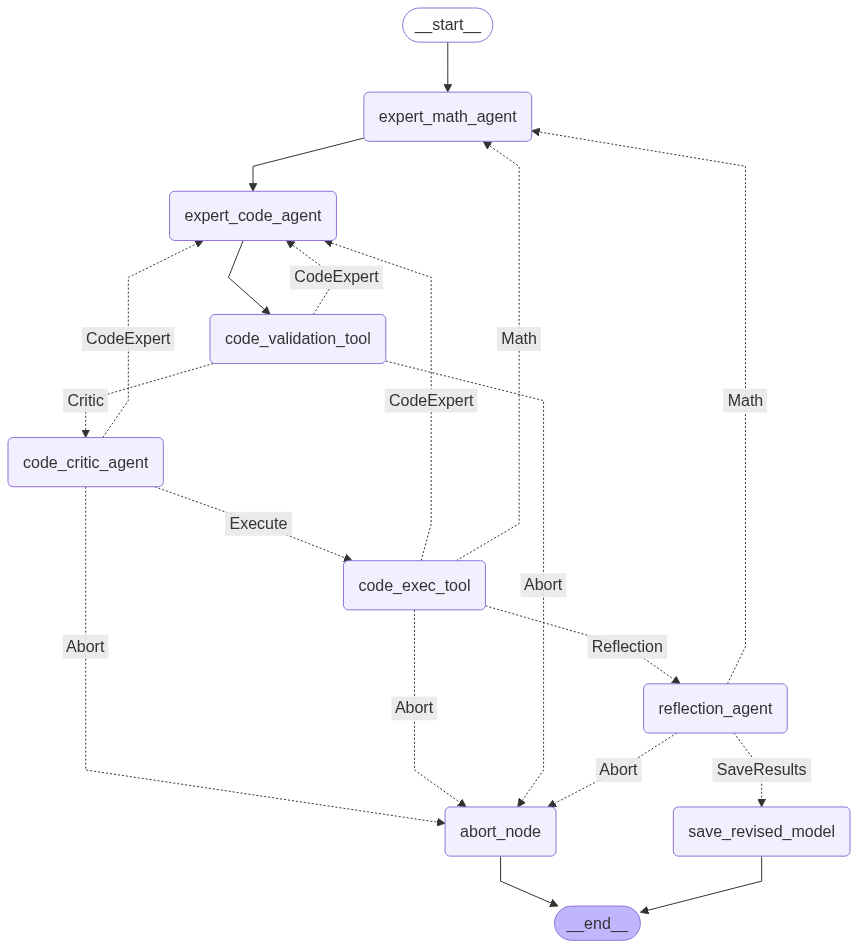

In [15]:
# Build the workflow graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("expert_math_agent", expert_math_agent)
workflow.add_node("expert_code_agent", expert_code_agent)
workflow.add_node("code_critic_agent", code_critic_agent)
workflow.add_node("reflection_agent", reflection_agent)
workflow.add_node("code_exec_tool", code_executor_node)
workflow.add_node("code_validation_tool", code_validator_node)
workflow.add_node("abort_node", end_execution_on_max_retries)
workflow.add_node("save_revised_model", save_model_node)

# Add edges to match the diagram
workflow.add_edge(START, "expert_math_agent")
workflow.add_edge("expert_math_agent", "expert_code_agent")
workflow.add_edge("expert_code_agent", "code_validation_tool")
workflow.add_conditional_edges(
    "code_validation_tool",
    post_code_validation_gate,
    {
        "Critic": "code_critic_agent", # follow happy path
        "CodeExpert": "expert_code_agent", # correct
        "Abort": "abort_node", # abort on max retries
    },
)
workflow.add_conditional_edges(
    "code_critic_agent",
    post_code_critic_gate,
    {
        "Execute": "code_exec_tool", # follow happy path
        "CodeExpert": "expert_code_agent", # correct
        "Abort": "abort_node", # abort on max retries
    },
)
workflow.add_conditional_edges(
    "code_exec_tool",
    post_code_execution_gate,
    {
        "Math": "expert_math_agent", # Infeasible solution
        "Reflection": "reflection_agent", # Happy path
        "CodeExpert": "expert_code_agent", # Correct execution errors
        "Abort": "abort_node", # abort on max retries
    },
)
workflow.add_conditional_edges(
    "reflection_agent",
    post_reflection_gate,
    {
        "Math": "expert_math_agent", # Non coherent solution
        "SaveResults": "save_revised_model", # Happy path
        "Abort": "abort_node", # abort on max retries
    },
)
workflow.add_edge("abort_node", END)
workflow.add_edge("save_revised_model", END)

# Compile the workflow
agent_v1 = workflow.compile()
# Show the workflow graph
display(Image(agent_v1.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Example invocation with optimization problem statement
initial_state = {
    "problem_statement": "Minimize 3x + 2y subject to x + y >= 10, x >= 0, y >= 0",
    "problem_name": "dummydemo_2",
    "expected_output": "Expected solution: x = 0, y = 10\nOptimal objective value: 20",
    "coherent": True,
    "execution_error": False
}

state = agent_v1.invoke(initial_state)

📐 [DEBUG] expert_math_agent: Starting mathematical formulation
------------------------------------------------------------------------------------------------------------------------
--> Problem Description
Minimize 3x + 2y subject to x + y >= 10, x >= 0, y >= 0
........................................................................................................................
--> Mathematical Problem Formulation:
Below is the structured mathematical model using the five-element framework:

--------------------------------------------------

Sets:
- V: set of decision variables, V = {x, y}

Parameters:
- cost_x: cost coefficient for variable x, cost_x = 3 (cost per unit, assumed in USD per unit)
- cost_y: cost coefficient for variable y, cost_y = 2 (cost per unit, assumed in USD per unit)
- min_total: minimum combined value required, min_total = 10 (unit: same units as x and y)

Variables:
- x: decision variable representing the quantity corresponding to cost coefficient 3 [contin

## 3. Running the Agent on the Text2Zinc Dataset

In [214]:
def execute_or_agent(problem_name, problem_data, expected_output):
    # Example invocation with optimization problem statement
    initial_state = {
        "problem_statement": problem_data,
        "problem_name": problem_name,
        "expected_output": f"Expected solution\n\n: {expected_output}",
        "coherent": True,
        "execution_error": False
    }
    agent_v1.invoke(initial_state)

In [ ]:
def pipeline(
        dataset,
        max_example_count = 1, 
        verbose = False,
        solved_problems = []
    ):
    counter = 0
    if counter <= max_example_count - 1 :
        # Extraer información detallada de cada ejemplo
        for example_num, data in dataset.items():
            print(f"\n{'='*60}")
            print(f"Problema {example_num}")
            print(f"{'='*60}")
            print("Checking if already solved")
            if int(example_num) in solved_problems:
                print(f"El problema {example_num} ya fue resuelto con exito")
            else:
                # Extraer descripción del input
                if 'input' in data:
                    input_data = data['input']
                    print(f"\n📋 DESCRIPCIÓN DEL INPUT:")
                    problem_name = input_data.get('metadata', {}).get('name', 'N/A')
                    problem_domain = input_data.get('metadata', {}).get('domain', 'N/A')
                    
                    print(f"Nombre: {problem_name}")
                    print(f"Dominio: {problem_domain}")
                    print("Generating prompt and starting agent..")

                # Generar prompt concatenando descripción, parámetros y datos
                prompt_parts = []
                
                # Agregar descripción (sin metadata)
                if 'input' in data and 'description' in data['input']:
                    prompt_parts.append(f"Take into account this a {problem_domain} problem.\n")
                    prompt_parts.append(f"Problem description: {data['input']['description']}")
                
                # Agregar parámetros
                if 'input' in data and 'parameters' in data['input']:
                    parameters = data['input']['parameters']
                    if parameters:
                        prompt_parts.append("\nProblem Parameters:")
                        for param in parameters:
                            symbol = param.get('symbol', 'N/A')
                            definition = param.get('definition', 'N/A')
                            shape = param.get('shape', 'N/A')
                            prompt_parts.append(f"- {symbol}: {definition} (shape: {shape})")
                
                # Agregar datos
                if 'data' in data:
                    data_content = data['data']
                    if isinstance(data_content, dict):
                        prompt_parts.append("\nProblem Data:")
                        for key, value in data_content.items():
                            prompt_parts.append(f"- {key}: {value}")
                    else:
                        prompt_parts.append(f"\nProblem Data: {data_content}")
                
                # Concatenar todo en un prompt
                if prompt_parts:
                    prompt = "\n".join(prompt_parts)
                    if verbose:
                        print(f"\n🤖 PROMPT GENERADO:")
                        print(f"{'='*50}")
                        print(prompt)
                        print(f"{'='*50}")


                # Extraer outputs del archivo output.json
                if 'output' in data:
                    expected_output_data = data['output']
                
                execute_or_agent(
                    problem_name=f"{example_num}_{problem_name.replace(" ", "_")}",
                    problem_data=prompt,
                    expected_output=expected_output_data
                )

                counter += 1
                print(f"\n{'-'*60}")

    print(f"\n{'='*60}")
    print(f"RESUMEN: Se analizaron {len(dataset)} ejemplos")
    print(f"{'='*60}")

In [215]:
dataset = read_all_examples(max_example=120)
len(dataset)

Se leyeron 120 ejemplos del dataset


120

In [216]:
sorted_examples = dict(sorted(dataset.items(), key=lambda x: int(x[0])))
sorted_examples.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119'])

In [ ]:
solved = [x for x in range(0, 102)]
solved[-1]

101

In [ ]:
pipeline(
    sorted_examples,
    max_example_count = 110, 
    verbose = False,
    solved_problems = solved
)

In [ ]:
from datasets import load_dataset

ds = load_dataset("skadio/text2zinc", split="train")
ds

Dataset({
    features: ['input.json', 'data.dzn', 'model.mzn', 'output.json', 'is_verified'],
    num_rows: 567
})

## 4. First Analysis of the Results

In [ ]:
verified = []

for example in ds:
    if example["is_verified"]:
        input_data = json.loads(example["input.json"])  # Parsear string JSON
        md = input_data["metadata"]
        verified.append(md)
print(f"- Verifieds: {len(verified)}")
v_df = pd.DataFrame(verified)
v_df["problem_number"] = v_df.index
v_df["problem_number"] = v_df["problem_number"].astype("str")
v_df.head()

- Verifieds: 110


,name,domain,objective,source,constraints,identifier,links,problem_number
0,P-Median Problem,Transportation and Logistics,minimization,hakank,"[forall, sum, =, <=, /\]",non_linear_problem_9,NaN,0
1,Road Illumination Optimization,Energy and Natural Resources,minimization,NLP4LP,"[forall, abs, <=, sum, *]",nlp4lp_10,NaN,1
2,Oil Refinery Production Optimization,Industrial Engineering and Design,maximization,NLP4LP,"[sum, <=, >=, forall]",nlp4lp_17,NaN,2
3,Aircraft Landing Problem,Scheduling,minimization,ComplexOR,"[forall, >=, sum, if, then, elseif, else, endif]",complexor_AircraftLanding,NaN,3
4,Economic Production Planning,Economic and Business Decisions,maximization,NLP4LP,"[forall, sum, <=, +]",nlp4lp_28,NaN,4


In [ ]:
results = pd.read_csv("RORA_results.csv")
results["Problema"] = results["Problema"].astype("str")

In [ ]:
results.dtypes

Problema                   object
Nombre                     object
Optimal Gen                object
Optimal Ground Truth       object
Optimal igual              object
Diferencia en objetivo     object
Comentarios                object
Problem Type               object
Accuracy                   object
Total                     float64
dtype: object

In [ ]:
import os

subcarpetas = [nombre for nombre in os.listdir("no_five_elements") if os.path.isdir(os.path.join("no_five_elements", nombre))]
problems = {}
for sub in subcarpetas:
    p_num = sub.split("_")[0]
    p_name = sub.replace(p_num+"_", "")
    problems[p_num] = p_name.replace("_", " ")

In [ ]:
curated_names = []

for index, row in results.iterrows():
    p_number = row["Problema"]
    try:
        curated_names.append(problems[p_number])
    except Exception as e:
        curated_names.append("Problem Timeouted")


In [ ]:
v_df

,name,domain,objective,source,constraints,identifier,links,problem_number
0,P-Median Problem,Transportation and Logistics,minimization,hakank,"[forall, sum, =, <=, /\]",non_linear_problem_9,NaN,0
1,Road Illumination Optimization,Energy and Natural Resources,minimization,NLP4LP,"[forall, abs, <=, sum, *]",nlp4lp_10,NaN,1
2,Oil Refinery Production Optimization,Industrial Engineering and Design,maximization,NLP4LP,"[sum, <=, >=, forall]",nlp4lp_17,NaN,2
3,Aircraft Landing Problem,Scheduling,minimization,ComplexOR,"[forall, >=, sum, if, then, elseif, else, endif]",complexor_AircraftLanding,NaN,3
4,Economic Production Planning,Economic and Business Decisions,maximization,NLP4LP,"[forall, sum, <=, +]",nlp4lp_28,NaN,4
...,...,...,...,...,...,...,...,...
105,Auto Parts Manufacturer Optimization,Manufacturing and Production,maximization,NLP4LP,"[forall, sum, <=, >=, *]",nlp4lp_62,NaN,105
106,Network Intrusion Response Optimization,Network and Security,minimization,NLP4LP,"[forall, =, sum, <=]",nlp4lp_65,NaN,106
107,Auto Parts Manufacturer Optimization,Manufacturing and Production,maximization,NLP4LP,"[forall, <=, >=, sum, -, *]",nlp4lp_53,NaN,107
108,Combinatorial Auction,Economic and Business Decisions,maximization,hakank,"[sum, bool2int, <=, forall]",combinatorial_problem_7,NaN,108


In [ ]:
results["curated_names"] = curated_names
results

,Problema,Nombre,Optimal Gen,Optimal Ground Truth,Optimal igual,Diferencia en objetivo,Comentarios,Problem Type,Accuracy,Total,curated_names
0,0,P Median Problem,"670,00","670,00",Si,0,NaN,Min,"56,36%",110.0,P-Median Problem
1,1,Road_Illumination_Optimization,"7,37","7,37",Si,0,NaN,Min,NaN,NaN,Road Illumination Optimization
2,2,Oil_Refinery_Production_Optimization,"245.000,00","339.000,00",No,-94000,Peor solucion,Max,NaN,NaN,Oil Refinery Production Optimization
3,3,Aircraft_Landing_Problem,"556,00","14.915,00",No,-14359,Nuestra solucion es mejor,Min,NaN,NaN,Aircraft Landing Problem
4,4,Economic_Production_Planning,"1.876,00","2.619,00",No,-743,Peor solucion,Max,NaN,NaN,Economic Production Planning
...,...,...,...,...,...,...,...,...,...,...,...
105,105,Auto_Parts_Manufacturer_Optimization,"7.080,00","7.120,00",No,105,"es max, tamos peor",NaN,NaN,NaN,Auto Parts Manufacturer Optimization
106,106,Network_Intrusion_Response_Optimization,"210,00","2.280,00",No,-2970,NaN,NaN,NaN,NaN,Network Intrusion Response Optimization
107,107,Auto_Parts_Manufacturer_Optimization,"10.050,00","9.750,00",No,199,es max asique nuetra sol seria mejor,NaN,NaN,NaN,Auto Parts Manufacturer Optimization
108,108,Combinatorial_Auction,"11,00","383,00",No,9315,NaN,NaN,NaN,NaN,Combinatorial Auction


In [ ]:
merged_df = results.merge(
    v_df, 
    left_on="Problema",
    right_on="problem_number",
    how="inner",
)
merged_df

,Problema,Nombre,Optimal Gen,Optimal Ground Truth,Optimal igual,Diferencia en objetivo,Comentarios,Problem Type,Accuracy,Total,curated_names,name,domain,objective,source,constraints,identifier,links,problem_number
0,0,P Median Problem,"670,00","670,00",Si,0,NaN,Min,"56,36%",110.0,P-Median Problem,P-Median Problem,Transportation and Logistics,minimization,hakank,"[forall, sum, =, <=, /\]",non_linear_problem_9,NaN,0
1,1,Road_Illumination_Optimization,"7,37","7,37",Si,0,NaN,Min,NaN,NaN,Road Illumination Optimization,Road Illumination Optimization,Energy and Natural Resources,minimization,NLP4LP,"[forall, abs, <=, sum, *]",nlp4lp_10,NaN,1
2,2,Oil_Refinery_Production_Optimization,"245.000,00","339.000,00",No,-94000,Peor solucion,Max,NaN,NaN,Oil Refinery Production Optimization,Oil Refinery Production Optimization,Industrial Engineering and Design,maximization,NLP4LP,"[sum, <=, >=, forall]",nlp4lp_17,NaN,2
3,3,Aircraft_Landing_Problem,"556,00","14.915,00",No,-14359,Nuestra solucion es mejor,Min,NaN,NaN,Aircraft Landing Problem,Aircraft Landing Problem,Scheduling,minimization,ComplexOR,"[forall, >=, sum, if, then, elseif, else, endif]",complexor_AircraftLanding,NaN,3
4,4,Economic_Production_Planning,"1.876,00","2.619,00",No,-743,Peor solucion,Max,NaN,NaN,Economic Production Planning,Economic Production Planning,Economic and Business Decisions,maximization,NLP4LP,"[forall, sum, <=, +]",nlp4lp_28,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,105,Auto_Parts_Manufacturer_Optimization,"7.080,00","7.120,00",No,105,"es max, tamos peor",NaN,NaN,NaN,Auto Parts Manufacturer Optimization,Auto Parts Manufacturer Optimization,Manufacturing and Production,maximization,NLP4LP,"[forall, sum, <=, >=, *]",nlp4lp_62,NaN,105
106,106,Network_Intrusion_Response_Optimization,"210,00","2.280,00",No,-2970,NaN,NaN,NaN,NaN,Network Intrusion Response Optimization,Network Intrusion Response Optimization,Network and Security,minimization,NLP4LP,"[forall, =, sum, <=]",nlp4lp_65,NaN,106
107,107,Auto_Parts_Manufacturer_Optimization,"10.050,00","9.750,00",No,199,es max asique nuetra sol seria mejor,NaN,NaN,NaN,Auto Parts Manufacturer Optimization,Auto Parts Manufacturer Optimization,Manufacturing and Production,maximization,NLP4LP,"[forall, <=, >=, sum, -, *]",nlp4lp_53,NaN,107
108,108,Combinatorial_Auction,"11,00","383,00",No,9315,NaN,NaN,NaN,NaN,Combinatorial Auction,Combinatorial Auction,Economic and Business Decisions,maximization,hakank,"[sum, bool2int, <=, forall]",combinatorial_problem_7,NaN,108


In [ ]:
merged_df =  merged_df[[
    "Problema",
    "name",
    "Optimal Gen",
    "Optimal Ground Truth",
    "domain",
    "objective",
    "source",
    "constraints",
    "identifier"
]]

In [ ]:
merged_df.to_csv("RORA_results_with_metadata.csv")
merged_df

,Problema,name,Optimal Gen,Optimal Ground Truth,domain,objective,source,constraints,identifier
0,0,P-Median Problem,"670,00","670,00",Transportation and Logistics,minimization,hakank,"[forall, sum, =, <=, /\]",non_linear_problem_9
1,1,Road Illumination Optimization,"7,37","7,37",Energy and Natural Resources,minimization,NLP4LP,"[forall, abs, <=, sum, *]",nlp4lp_10
2,2,Oil Refinery Production Optimization,"245.000,00","339.000,00",Industrial Engineering and Design,maximization,NLP4LP,"[sum, <=, >=, forall]",nlp4lp_17
3,3,Aircraft Landing Problem,"556,00","14.915,00",Scheduling,minimization,ComplexOR,"[forall, >=, sum, if, then, elseif, else, endif]",complexor_AircraftLanding
4,4,Economic Production Planning,"1.876,00","2.619,00",Economic and Business Decisions,maximization,NLP4LP,"[forall, sum, <=, +]",nlp4lp_28
...,...,...,...,...,...,...,...,...,...
105,105,Auto Parts Manufacturer Optimization,"7.080,00","7.120,00",Manufacturing and Production,maximization,NLP4LP,"[forall, sum, <=, >=, *]",nlp4lp_62
106,106,Network Intrusion Response Optimization,"210,00","2.280,00",Network and Security,minimization,NLP4LP,"[forall, =, sum, <=]",nlp4lp_65
107,107,Auto Parts Manufacturer Optimization,"10.050,00","9.750,00",Manufacturing and Production,maximization,NLP4LP,"[forall, <=, >=, sum, -, *]",nlp4lp_53
108,108,Combinatorial Auction,"11,00","383,00",Economic and Business Decisions,maximization,hakank,"[sum, bool2int, <=, forall]",combinatorial_problem_7


In [ ]:
count_equal = (merged_df["Optimal Gen"] == merged_df["Optimal Ground Truth"]).sum()
plain_acc = round(count_equal/merged_df.shape[0], 4)

print(f"Plain Accuracy: {plain_acc}")


Plain Accuracy: 0.5636


In [ ]:
import numpy as np

def parse_number(s):
    if isinstance(s, str):
        s = s.replace('.', '').replace(',', '.')
        try:
            return float(s)
        except:
            return np.nan
    return np.nan

gen_vals = merged_df["Optimal Gen"].apply(parse_number)
gt_vals = merged_df["Optimal Ground Truth"].apply(parse_number)

# Avoid division by zero and nan
mask = (~np.isnan(gen_vals)) & (~np.isnan(gt_vals)) & (gt_vals != 0)
rel_diff = np.full_like(gen_vals, np.nan, dtype=np.float64)
rel_diff[mask] = np.abs(gen_vals[mask] - gt_vals[mask]) / np.abs(gt_vals[mask])

count_within_5pct = np.nansum(rel_diff < 0.05)
acc_5pct = round(count_within_5pct / np.sum(mask), 4) if np.sum(mask) > 0 else np.nan

print(f"Accuracy within 5%: {acc_5pct}")


Accuracy within 5%: 0.6422


/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_19815/648069894.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  domain_acc = merged_df.groupby('domain').apply(
/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_19815/648069894.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  objective_acc = merged_df.groupby('objective').apply(
/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_1981

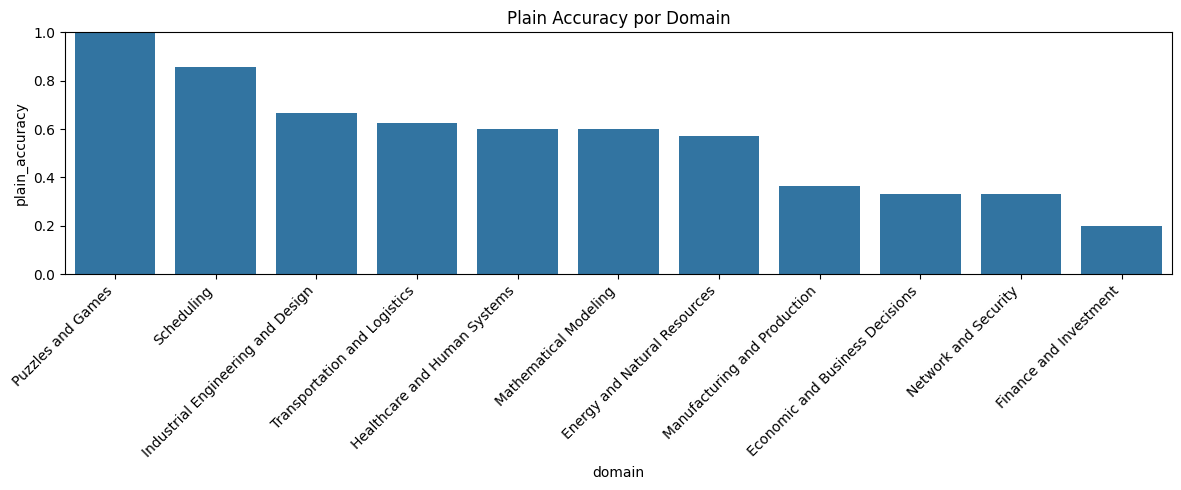

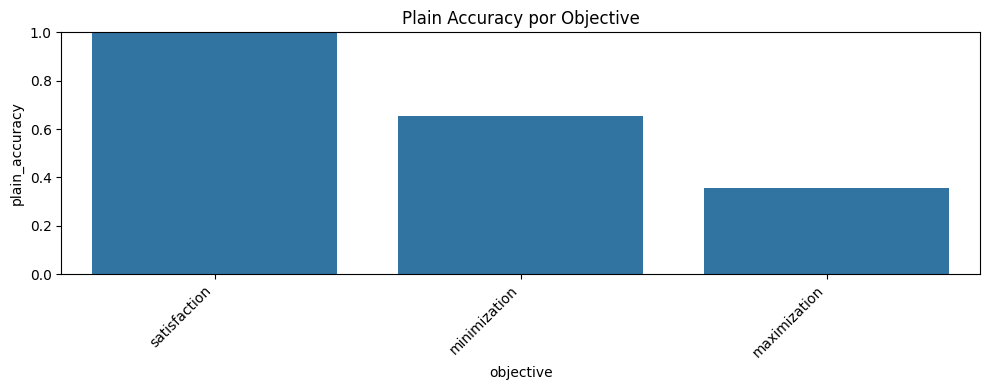

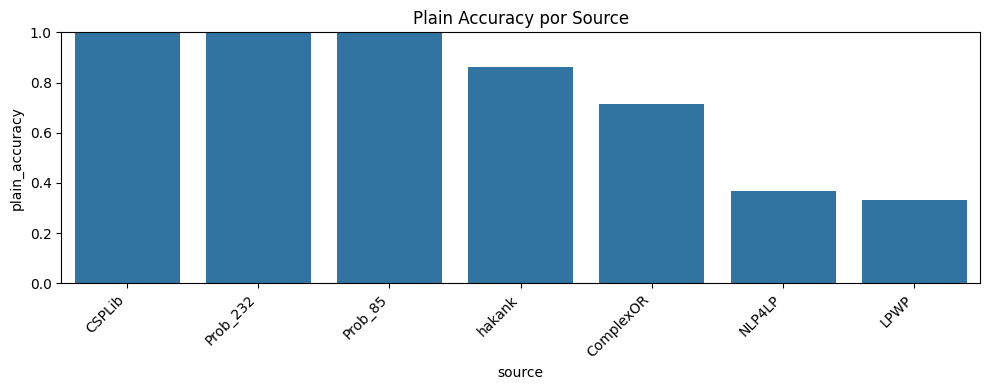

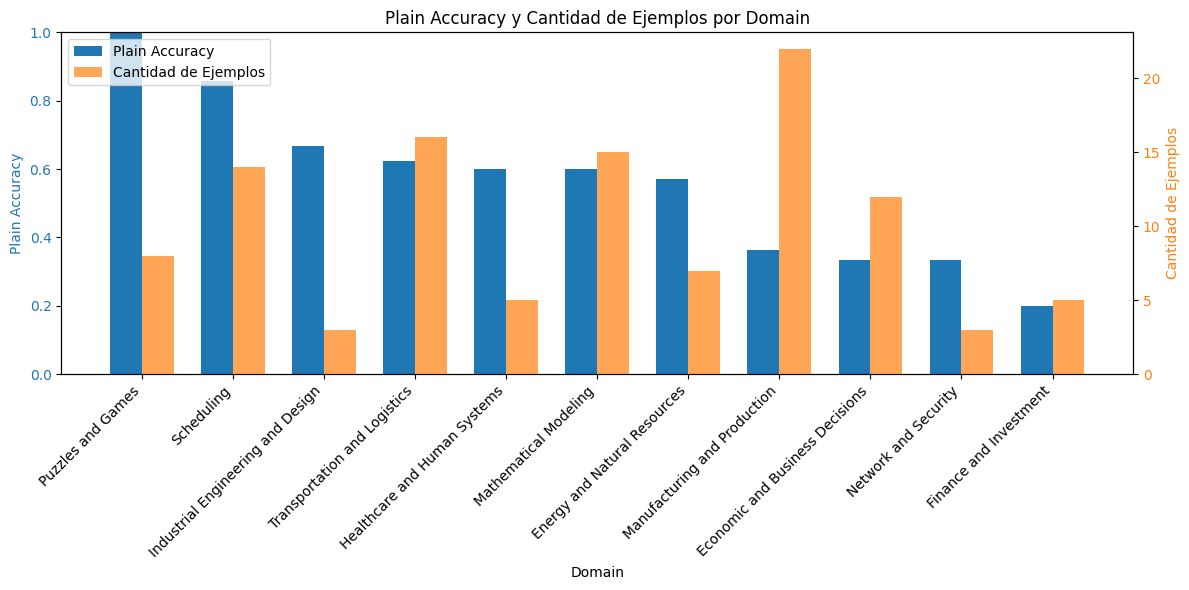

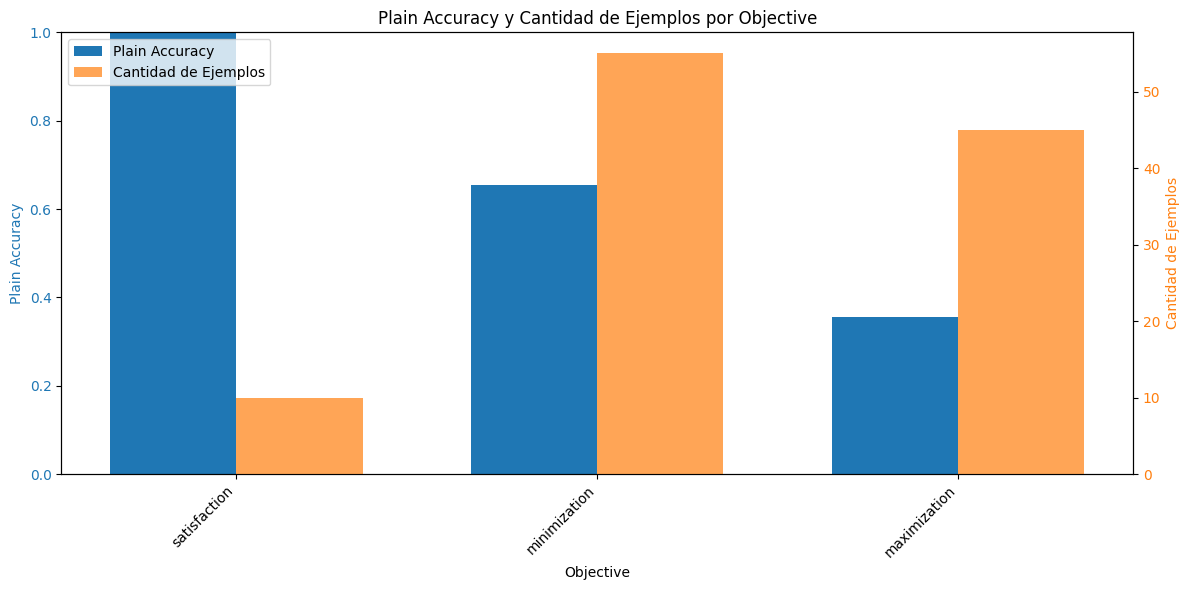

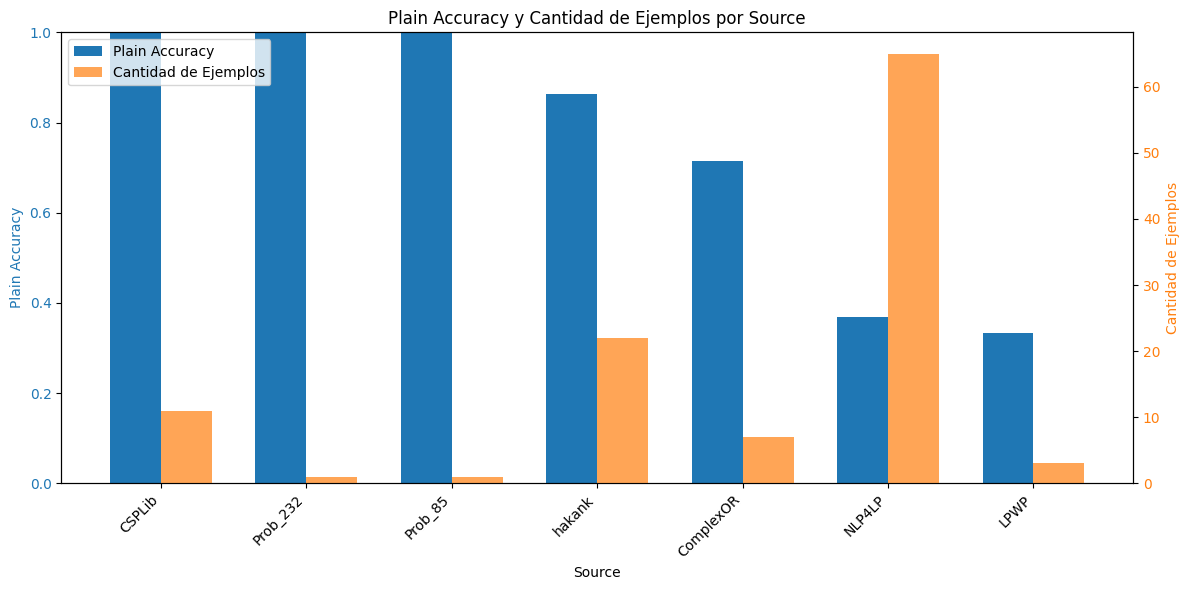

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Plain accuracy por domain + cantidad de ejemplos
domain_acc = merged_df.groupby('domain').apply(
    lambda df: (df["Optimal Gen"] == df["Optimal Ground Truth"]).sum() / len(df)
).reset_index(name='plain_accuracy')
domain_acc['count'] = merged_df.groupby('domain').size().values

# 2. Plain accuracy por objective + cantidad de ejemplos
objective_acc = merged_df.groupby('objective').apply(
    lambda df: (df["Optimal Gen"] == df["Optimal Ground Truth"]).sum() / len(df)
).reset_index(name='plain_accuracy')
objective_acc['count'] = merged_df.groupby('objective').size().values

# 3. Plain accuracy por source + cantidad de ejemplos
source_acc = merged_df.groupby('source').apply(
    lambda df: (df["Optimal Gen"] == df["Optimal Ground Truth"]).sum() / len(df)
).reset_index(name='plain_accuracy')
source_acc['count'] = merged_df.groupby('source').size().values

# Plots: solo plain accuracy
plt.figure(figsize=(12, 5))
sns.barplot(data=domain_acc.sort_values('plain_accuracy', ascending=False), x='domain', y='plain_accuracy')
plt.title('Plain Accuracy por Domain')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=objective_acc.sort_values('plain_accuracy', ascending=False), x='objective', y='plain_accuracy')
plt.title('Plain Accuracy por Objective')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=source_acc.sort_values('plain_accuracy', ascending=False), x='source', y='plain_accuracy')
plt.title('Plain Accuracy por Source')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Bar plots dobles: accuracy y cantidad de ejemplos por categoria (domain, objective, source)
def dual_barplot(df, x_col, acc_label, count_label, title, xlabel, acc_color='#1f77b4', count_color='#ff7f0e'):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df[x_col]))
    width = 0.35

    # Accuracy bar
    bars1 = ax1.bar(x - width/2, df[acc_label], width, label='Plain Accuracy', color=acc_color)
    ax1.set_ylabel('Plain Accuracy', color=acc_color)
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='y', labelcolor=acc_color)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df[x_col], rotation=45, ha='right')
    ax1.set_xlabel(xlabel)
    ax1.set_title(title)

    # Count bar (secondary axis)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, df[count_label], width, label='Cantidad de Ejemplos', color=count_color, alpha=0.7)
    ax2.set_ylabel('Cantidad de Ejemplos', color=count_color)
    ax2.tick_params(axis='y', labelcolor=count_color)

    # Legends
    ax1.legend([bars1, bars2], ['Plain Accuracy', 'Cantidad de Ejemplos'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Domain
dual_barplot(
    domain_acc.sort_values('plain_accuracy', ascending=False).reset_index(drop=True),
    x_col='domain',
    acc_label='plain_accuracy',
    count_label='count',
    title='Plain Accuracy y Cantidad de Ejemplos por Domain',
    xlabel='Domain'
)

# Objective
dual_barplot(
    objective_acc.sort_values('plain_accuracy', ascending=False).reset_index(drop=True),
    x_col='objective',
    acc_label='plain_accuracy',
    count_label='count',
    title='Plain Accuracy y Cantidad de Ejemplos por Objective',
    xlabel='Objective'
)

# Source
dual_barplot(
    source_acc.sort_values('plain_accuracy', ascending=False).reset_index(drop=True),
    x_col='source',
    acc_label='plain_accuracy',
    count_label='count',
    title='Plain Accuracy y Cantidad de Ejemplos por Source',
    xlabel='Source'
)


### 4.1 Re run only for satisfaction problems

In [226]:
merged_df.domain.unique()

array(['Transportation and Logistics', 'Energy and Natural Resources',
       'Industrial Engineering and Design', 'Scheduling',
       'Economic and Business Decisions', 'Puzzles and Games',
       'Manufacturing and Production', 'Mathematical Modeling',
       'Finance and Investment', 'Healthcare and Human Systems',
       'Network and Security'], dtype=object)

In [235]:
test = merged_df[merged_df.source != "NLP4LP"]
test.shape

(45, 10)

In [236]:
test.to_csv("text_2_zinc_results_non4lp.csv")

In [232]:
test[test["Optimal Gen"]==test["Optimal Ground Truth"]].shape

(38, 10)

In [234]:
test

,Unnamed: 0,Problema,name,Optimal Gen,Optimal Ground Truth,domain,objective,source,constraints,identifier
0,0,0,P-Median Problem,"670,00","670,00",Transportation and Logistics,minimization,hakank,"['forall', 'sum', '=', '<=', '/\\']",non_linear_problem_9
3,3,3,Aircraft Landing Problem,"556,00","14.915,00",Scheduling,minimization,ComplexOR,"['forall', '>=', 'sum', 'if', 'then', 'elseif'...",complexor_AircraftLanding
5,5,5,Fill-a-Pix,"-1,00","-1,00",Puzzles and Games,satisfaction,hakank,"['sum', 'implies', '<=', '>', 'and', 'forall']",puzzles_problem_31
7,7,7,Nonogram Solver,"-1,00","-1,00",Puzzles and Games,satisfaction,CSPLib,"['forall', 'make_automaton', 'regular']",CSPLib_12
9,9,9,Aircraft Assignment Problem,"140,00","140,00",Transportation and Logistics,minimization,ComplexOR,"['forall', 'sum', '<=', '>=', '*']",complexor_AircraftAssignment
10,10,10,Science Fair Table Optimization,"1.080,00","1.080,00",Mathematical Modeling,maximization,Prob_232,"['sum', '<=', '>=', 'maximization']",LPWP_232
16,16,16,Solitaire Battleships,"-1,00","-1,00",Puzzles and Games,satisfaction,CSPLib,"['forall', 'if', 'then', 'endif', 'bool2int', ...",CSPLib_14
18,18,18,Bus Driver Scheduling,"7,00","7,00",Scheduling,minimization,CSPLib,"['sum', 'bool2int', '>=', '=']",CSPLib_22
21,21,21,Golomb Rulers,"55,00","55,00",Mathematical Modeling,minimization,CSPLib,"['alldifferent', '<', 'forall']",CSPLib_6
24,24,24,Currency Arbitrage Detection,"1,01","1,01",Finance and Investment,maximization,hakank,"['totalProfit >= 0.0', 'all_different', '=', '...",non_linear_problem_23


In [ ]:
pipeline(
    sorted_examples,
    max_example_count = 110, 
    verbose = False,
    solved_problems = solved
)

## 5. Re-running LP problems with No-Latex formulations to check for improvements

In [ ]:
import pandas as pd

merged_df = pd.read_csv("RORA_results_with_metadata.csv")
merged_df

,Unnamed: 0,Problema,name,Optimal Gen,Optimal Ground Truth,domain,objective,source,constraints,identifier
0,0,0,P-Median Problem,"670,00","670,00",Transportation and Logistics,minimization,hakank,"['forall', 'sum', '=', '<=', '/\\']",non_linear_problem_9
1,1,1,Road Illumination Optimization,"7,37","7,37",Energy and Natural Resources,minimization,NLP4LP,"['forall', 'abs', '<=', 'sum', '*']",nlp4lp_10
2,2,2,Oil Refinery Production Optimization,"245.000,00","339.000,00",Industrial Engineering and Design,maximization,NLP4LP,"['sum', '<=', '>=', 'forall']",nlp4lp_17
3,3,3,Aircraft Landing Problem,"556,00","14.915,00",Scheduling,minimization,ComplexOR,"['forall', '>=', 'sum', 'if', 'then', 'elseif'...",complexor_AircraftLanding
4,4,4,Economic Production Planning,"1.876,00","2.619,00",Economic and Business Decisions,maximization,NLP4LP,"['forall', 'sum', '<=', '+']",nlp4lp_28
...,...,...,...,...,...,...,...,...,...,...
105,105,105,Auto Parts Manufacturer Optimization,"7.080,00","7.120,00",Manufacturing and Production,maximization,NLP4LP,"['forall', 'sum', '<=', '>=', '*']",nlp4lp_62
106,106,106,Network Intrusion Response Optimization,"210,00","2.280,00",Network and Security,minimization,NLP4LP,"['forall', '=', 'sum', '<=']",nlp4lp_65
107,107,107,Auto Parts Manufacturer Optimization,"10.050,00","9.750,00",Manufacturing and Production,maximization,NLP4LP,"['forall', '<=', '>=', 'sum', '-', '*']",nlp4lp_53
108,108,108,Combinatorial Auction,"11,00","383,00",Economic and Business Decisions,maximization,hakank,"['sum', 'bool2int', '<=', 'forall']",combinatorial_problem_7


In [ ]:
# Filtrar los problemas cuyo source sea 'NLP4LP' o 'LPWP' y que estén mal resueltos (óptimo generado distinto al ground truth)
problemas_nlplp_lpwp_mal = merged_df[
    merged_df['source'].isin(['NLP4LP', 'LPWP']) &
    (merged_df['Optimal Gen'] != merged_df['Optimal Ground Truth'])
]
problemas_nlplp_lpwp_mal.shape


(43, 10)

In [115]:
# Mostrar la lista de nombres de los problemas
lista_problemas = problemas_nlplp_lpwp_mal['Problema'].tolist()
print(lista_problemas)

[2, 4, 6, 8, 11, 13, 14, 15, 17, 19, 22, 23, 29, 32, 38, 39, 41, 42, 45, 46, 47, 51, 56, 58, 63, 65, 66, 67, 71, 73, 75, 76, 77, 79, 84, 86, 91, 101, 102, 105, 106, 107, 109]


In [ ]:
lista_problemas.pop(lista_problemas.index(2))
print(lista_problemas)

[4, 6, 8, 11, 13, 14, 15, 17, 19, 22, 23, 29, 32, 38, 39, 41, 42, 45, 46, 47, 51, 56, 58, 63, 65, 66, 67, 71, 73, 75, 76, 77, 79, 84, 86, 91, 101, 102, 105, 106, 107, 109]


In [ ]:
def pipeline_with_specific_targets(
        dataset,
        target_problems=None,  # Nueva lista de problemas a correr (números de problema)
        verbose=False,
        solved_problems=[]
    ):
    """
    Ejecuta el pipeline SOLO para los problemas especificados en target_problems (lista de números de problema).
    """
    if target_problems is None:
        print("Debes especificar una lista de problemas target en target_problems.")
        return

    # Asegurarse de que los números de problema sean strings para coincidir con las keys del dataset
    target_problems_str = set(str(p) for p in target_problems)

    total_analizados = 0

    for example_num, data in dataset.items():
        if example_num not in target_problems_str:
            continue  # Saltar si no está en la lista target

        print(f"\n{'='*60}")
        print(f"Problema {example_num}")
        print(f"{'='*60}")
        print("Checking if already solved")
        if int(example_num) in solved_problems:
            print(f"El problema {example_num} ya fue resuelto con exito")
            continue

        # Extraer descripción del input
        if 'input' in data:
            input_data = data['input']
            print(f"\n📋 DESCRIPCIÓN DEL INPUT:")
            problem_name = input_data.get('metadata', {}).get('name', 'N/A')
            problem_domain = input_data.get('metadata', {}).get('domain', 'N/A')
            
            print(f"Nombre: {problem_name}")
            print(f"Dominio: {problem_domain}")
            print("Generating prompt and starting agent..")
        else:
            problem_name = "N/A"
            problem_domain = "N/A"

        # Generar prompt concatenando descripción, parámetros y datos
        prompt_parts = []
        
        # Agregar descripción (sin metadata)
        if 'input' in data and 'description' in data['input']:
            prompt_parts.append(f"Take into account this a {problem_domain} problem.\n")
            prompt_parts.append(f"Problem description: {data['input']['description']}")
        
        # Agregar parámetros
        if 'input' in data and 'parameters' in data['input']:
            parameters = data['input']['parameters']
            if parameters:
                prompt_parts.append("\nProblem Parameters:")
                for param in parameters:
                    symbol = param.get('symbol', 'N/A')
                    definition = param.get('definition', 'N/A')
                    shape = param.get('shape', 'N/A')
                    prompt_parts.append(f"- {symbol}: {definition} (shape: {shape})")
        
        # Agregar datos
        if 'data' in data:
            data_content = data['data']
            if isinstance(data_content, dict):
                prompt_parts.append("\nProblem Data:")
                for key, value in data_content.items():
                    prompt_parts.append(f"- {key}: {value}")
            else:
                prompt_parts.append(f"\nProblem Data: {data_content}")
        
        # Concatenar todo en un prompt
        if prompt_parts:
            prompt = "\n".join(prompt_parts)
            if verbose:
                print(f"\n🤖 PROMPT GENERADO:")
                print(f"{'='*50}")
                print(prompt)
                print(f"{'='*50}")
        else:
            prompt = ""

        # Extraer outputs del archivo output.json
        if 'output' in data:
            expected_output_data = data['output']
        else:
            expected_output_data = None
        
        execute_or_agent(
            problem_name=f"{example_num}_{problem_name.replace(' ', '_')}",
            problem_data=prompt,
            expected_output=expected_output_data
        )

        total_analizados += 1
        print(f"\n{'-'*60}")

    print(f"\n{'='*60}")
    print(f"RESUMEN: Se analizaron {total_analizados} ejemplos (target problems)")
    print(f"{'='*60}")

In [ ]:

pipeline_with_specific_targets(
    sorted_examples,
    target_problems=lista_problemas,  # Nueva lista de problemas a correr (números de problema)
    verbose=False,
    solved_problems=[]
)

> ### Just a quick check for verified results

In [ ]:
from datasets import load_dataset

# Cargar el dataset directamente desde HuggingFace
ds = load_dataset("skadio/text2zinc", split="train")

# Filtrar ejemplos que están verificados pero no tienen model.mzn
missing_model_and_validated = [
    example for example in ds
    if example["is_verified"] and (example["model.mzn"] is None or example["model.mzn"].strip() == "")
]

# Cantidad de ejemplos que cumplen la condición
missing_model_and_validated

[{'input.json': '{"parameters": [{"definition": "Total number of years in the planning horizon", "symbol": "K", "shape": []}, {"definition": "Input one coefficients matrix", "symbol": "InputOne", "shape": ["K", "K"]}, {"definition": "Manpower coefficients for input one", "symbol": "ManpowerOne", "shape": ["K"]}, {"definition": "Input two coefficients matrix", "symbol": "InputTwo", "shape": ["K", "K"]}, {"definition": "Manpower coefficients for input two", "symbol": "ManpowerTwo", "shape": ["K"]}, {"definition": "Initial stock level for each of the productive units", "symbol": "Stock", "shape": ["K"]}, {"definition": "Productive capacity for each productive unit", "symbol": "Capacity", "shape": ["K"]}, {"definition": "Company-wide manpower limit", "symbol": "ManpowerLimit", "shape": []}, {"definition": "Demand for each of the productive units at the end of the planning horizon", "symbol": "Demand", "shape": ["K"]}], "description": "An economy consists of several industries. Each unit pr

## 6. Downloading NLP4LP directly, composing CP + NLP dataset for evals

In [ ]:
from datasets import load_dataset
import os
import json
from tqdm import tqdm
from huggingface_hub import login

login(token="")

# Download the dataset from HuggingFace
ds = load_dataset("udell-lab/NLP4LP", split="test")

# Filter entries where solution is not an empty dict
filtered = [ex for ex in ds if ex.get("solution", None) not in ("{}", {}, None, "")]

# Make sure the output directory exists
os.makedirs("nlp4lp", exist_ok=True)

# Save each filtered entry as a JSON file in the nlp4lp folder
for i, ex in enumerate(tqdm(filtered, desc="Saving filtered NLP4LP entries")):
    # Use a unique filename, e.g., by index or by problem name if available
    fname = f"nlp4lp/entry_{i}.json"
    with open(fname, "w", encoding="utf-8") as f:
        json.dump(ex, f, ensure_ascii=False, indent=2)

print(f"Saved {len(filtered)} entries to the 'nlp4lp' folder.")


Saving filtered NLP4LP entries: 100%|██████████| 242/242 [00:00<00:00, 4124.83it/s]

Saved 242 entries to the 'nlp4lp' folder.


In [156]:
import json

def generate_solution_schema(entry_json):
    """
    Dado un JSON de entrada (como dict o str), genera un schema del campo 'solution'.
    El schema es un dict que describe los tipos de los campos y su estructura.
    """
    # Si es string, parsear
    if isinstance(entry_json, str):
        entry = json.loads(entry_json)
    else:
        entry = entry_json

    # Obtener el campo 'solution'
    solution_str = entry.get("solution", None)
    if solution_str is None:
        return None
    # Si es string, parsear
    if isinstance(solution_str, str):
        try:
            solution = json.loads(solution_str)
        except Exception:
            # Si ya es dict en string, pero mal formateado
            return None
    else:
        solution = solution_str

    def infer_schema(obj):
        if isinstance(obj, dict):
            return {k: infer_schema(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            if not obj:
                return []
            # Infer schema of first element (assume homogeneous)
            return [infer_schema(obj[0])]
        else:
            return type(obj).__name__

    return infer_schema(solution)

# Ejemplo de uso:
with open("nlp4lp/entry_88.json", "r") as f:
    entry = json.load(f)

schema = generate_solution_schema(entry)
print(json.dumps(schema, indent=2, ensure_ascii=False))


{
  "variables": {
    "RegularBatches": "float",
    "PremiumBatches": "float"
  },
  "objective": "float"
}


In [195]:
def infer_schema(obj):
    if isinstance(obj, dict):
        return {k: infer_schema(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        if not obj:
            return []
        # Infer schema of first element (assume homogeneous)
        return [infer_schema(obj[0])]
    else:
        return type(obj).__name__
    
def pipeline_with_specific_targets_nlp4lp(
        nlp4lp_dir,
        target_problems=None,  # Lista de números de problema (índices de los archivos nlp4lp)
        verbose=False,
        solved_problems=[]
    ):
    """
    Ejecuta el pipeline SOLO para los problemas especificados en target_problems (lista de números de problema).
    Lee los ejemplos directamente de los archivos nlp4lp/entry_{num}.json y agrega el expected output al final de la descripción.
    Además, mide el tiempo de ejecución de cada problema y lo guarda junto con los resultados.
    """
    import os
    import json
    import time

    if target_problems is None:
        # Si no se especifica target_problems, usar todos los problemas disponibles en el directorio
        target_problems = []
        for fname in os.listdir(nlp4lp_dir):
            if fname.startswith("entry_") and fname.endswith(".json"):
                try:
                    num = fname[len("entry_"):-len(".json")]
                    int(num)  # check it's a number
                    target_problems.append(num)
                except Exception:
                    continue
        target_problems = sorted(target_problems, key=lambda x: int(x))

    # Asegurarse de que los números de problema sean strings para coincidir con los nombres de archivo
    target_problems_str = set(str(p) for p in target_problems)

    total_analizados = 0

    # Para guardar los tiempos de ejecución y resultados
    execution_times = {}
    execution_results = {}

    for example_num in target_problems_str:
        entry_path = os.path.join(nlp4lp_dir, f"entry_{example_num}.json")
        if not os.path.exists(entry_path):
            print(f"Archivo {entry_path} no encontrado, saltando.")
            continue

        print(f"\n{'='*60}")
        print(f"Problema {example_num}")
        print(f"{'='*60}")
        print("Checking if already solved")
        if int(example_num) in solved_problems or str(example_num) in solved_problems:
            print(f"El problema {example_num} ya fue resuelto con exito")
            continue

        # Leer el archivo nlp4lp/entry_{num}.json
        with open(entry_path, "r") as f:
            entry = json.load(f)

        # Extraer campos relevantes
        description = entry.get("description", "N/A")
        parameters_str = entry.get("parameters", None)
        parameters = None
        if parameters_str:
            try:
                parameters = json.loads(parameters_str)
            except Exception:
                parameters = None
        problem_info_str = entry.get("problem_info", None)
        problem_info = None
        if problem_info_str:
            try:
                problem_info = json.loads(problem_info_str)
            except Exception:
                problem_info = None
        solution_str = entry.get("solution", None)
        solution = None
        if solution_str:
            try:
                solution = json.loads(solution_str)
            except Exception:
                solution = solution_str  # Si no es JSON, dejar como string

        # Metadata
        metadata = {}
        if problem_info and isinstance(problem_info, dict):
            metadata = problem_info.get("metadata", {})
        problem_name = metadata.get("name", f"nlp4lp_{example_num}")
        problem_domain = metadata.get("domain", "N/A")

        print(f"\n📋 DESCRIPCIÓN DEL INPUT:")
        print(f"Nombre: {problem_name}")
        print(f"Dominio: {problem_domain}")
        print("Generating prompt and starting agent..")

        # Generar prompt concatenando descripción, parámetros y datos
        prompt_parts = []
        prompt_parts.append(f"Problem description: {description}")

        # Agregar expected output al final de la descripción
        if solution is not None:
            prompt_parts.append("\nExpected Output Schema:")
            solution_schema = infer_schema(solution)
            print("solution schema: ", solution_schema)
            prompt_parts.append(json.dumps(solution_schema, indent=2, ensure_ascii=False))

        # Concatenar todo en un prompt
        prompt = "\n".join(prompt_parts)
        if verbose:
            print(f"\n🤖 PROMPT GENERADO:")
            print(f"{'='*50}")
            print(prompt)
            print(f"{'='*50}")

        # El expected_output es el mismo que el solution
        expected_output_data = solution

        # Medir el tiempo de ejecución
        start_time = time.time()
        result = execute_or_agent(
            problem_name=f"{example_num}_{problem_name.replace(' ', '_')}",
            problem_data=prompt,
            expected_output=expected_output_data
        )
        end_time = time.time()
        elapsed = end_time - start_time

        print(f"\n⏱️ Tiempo de ejecución para el problema {example_num}: {elapsed:.3f} segundos")
        total_analizados += 1
        print(f"\n{'-'*60}")

        # Guardar los tiempos y resultados en archivos JSON
        # Write the execution time to a txt file
        with open(f"nlp4lp_results/{example_num}_nlp4lp_{example_num}/execution_time.txt", "w") as f:
            f.write(f"{elapsed:.3f} seconds\n")
       
    print(f"\n{'='*60}")
    print(f"RESUMEN: Se analizaron {total_analizados} ejemplos (target problems)")
    print(f"{'='*60}")

In [199]:
import os
import re

def concat_nlp4lp_execution_results(results_dir="nlp4lp_results", output_file="nlp4lp_results/all_nlp4lp_execution_results.txt"):
    """
    Lee todos los .txt de los modelos resueltos de nlp4lp y concatena todo lo que encuentre después de 'Execution Results'
    (incluyendo 'Execution Results') en un solo archivo txt. Antes de cada resultado, indica a qué problema corresponde,
    mostrando el número de problema, la solución propuesta y la solución esperada.
    """
    all_results = []
    # Buscar todos los subdirectorios que tengan un archivo *_results.txt
    for subdir in sorted(os.listdir(results_dir), key=lambda x: int(re.findall(r'\d+', x)[0]) if re.findall(r'\d+', x) else 0):
        subdir_path = os.path.join(results_dir, subdir)
        if not os.path.isdir(subdir_path):
            continue
        # Buscar el archivo *_results.txt
        txt_files = [f for f in os.listdir(subdir_path) if f.endswith("_results.txt")]
        if not txt_files:
            continue
        txt_file = txt_files[0]
        txt_path = os.path.join(subdir_path, txt_file)
        with open(txt_path, "r", encoding="utf-8") as f:
            content = f.read()
        # Buscar el número de problema
        m = re.search(r"Problem Name:\s*([^\n]*)", content)
        problem_name = m.group(1).strip() if m else subdir
        m_num = re.search(r"(\d+)", subdir)
        problem_num = m_num.group(1) if m_num else subdir

        # Buscar Execution Results y Expected Output
        exec_match = re.search(r"(Execution Results:[\s\S]+?)(?=Expected Output:|$)", content)
        exec_results = exec_match.group(1).strip() if exec_match else "No execution results found."
        expected_match = re.search(r"Expected Output:[\s\S]+", content)
        expected_results = expected_match.group(0).strip() if expected_match else "No expected output found."

        # Formatear el bloque
        block = []
        block.append(f"Problem {problem_num}: {problem_name}")
        block.append("- Proposed solution:")
        block.append(exec_results)
        block.append("- Expected solution:")
        block.append(expected_results)
        block.append("\n" + "="*80 + "\n")
        all_results.append("\n".join(block))

    # Guardar en el archivo de salida
    with open(output_file, "w", encoding="utf-8") as out_f:
        out_f.write("\n".join(all_results))
    print(f"Archivo generado: {output_file}")

concat_nlp4lp_execution_results()

Archivo generado: nlp4lp_results/all_nlp4lp_execution_results.txt


In [200]:
def get_solved_nlp4lp_problems(results_dir="nlp4lp_results"):
    """
    Devuelve una lista con los números (o nombres) de todos los problemas que ya fueron resueltos
    dentro del directorio nlp4lp_results. Considera como resuelto cualquier subdirectorio que contenga
    un archivo *_results.txt.
    """
    import os
    solved = []
    for subdir in os.listdir(results_dir):
        subdir_path = os.path.join(results_dir, subdir)
        if not os.path.isdir(subdir_path):
            continue
        txt_files = [f for f in os.listdir(subdir_path) if f.endswith("_results.txt")]
        if txt_files:
            # Extraer número de problema si está en el nombre del subdirectorio, si no, usar el nombre
            import re
            m = re.search(r"(\d+)", subdir)
            if m:
                solved.append(m.group(1))
            else:
                solved.append(subdir)
    return solved

solved_nlp4lp = get_solved_nlp4lp_problems()
print(solved_nlp4lp)

['82', '181', '46', '6', '57', '173', '234', '122', '93', '25', '218', '140', '207', '111', '34', '55', '91', '144', '7', '80', '203', '44', '115', '185', '139', '36', '168', '177', '230', '27', '126', '214', '153', '102', '21', '69', '78', '30', '42', '227', '160', '86', '131', '192', '97', '4', '238', '53', '223', '164', '32', '189', '135', '196', '23', '5', '95', '210', '157', '51', '19', '241', '106', '119', '40', '148', '84', '90', '208', '54', '101', '45', '150', '217', '81', '37', '191', '132', '3', '163', '224', '26', '47', '178', '83', '195', '129', '136', '92', '167', '56', '220', '24', '105', '35', '154', '213', '33', '1', '237', '170', '22', '228', '182', '50', '112', '18', '204', '143', '94', '85', '41', '20', '116', '68', '200', '147', '158', '0', '79', '109', '31', '199', '125', '87', '43', '233', '2', '174', '52', '96', '186', '134', '188', '165', '222', '62', '73', '197', '49', '107', '240', '156', '211', '149', '118', '58', '10', '103', '71', '39', '152', '215', '28',

In [201]:
len(solved_nlp4lp)

241

In [ ]:
solved_nlp_4lp = solved_nlp4lp+[121, "121", "46", 46]
solved_nlp4lp.index("2")

127

In [205]:
solved_nlp4lp.pop(127)

'174'

In [ ]:
pipeline_with_specific_targets_nlp4lp(
    nlp4lp_dir="nlp4lp",
    verbose=True,
    solved_problems=solved_nlp4lp+[121, "121"]
)

In [238]:
import os

execution_times = []
base_dir = "nlp4lp_results"

for subdir, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "execution_time.txt":
            file_path = os.path.join(subdir, file)
            try:
                with open(file_path, "r") as f:
                    content = f.read().strip()
                    content = content.split(" ")[0]
                    # Try to parse as float, fallback to string if not possible
                    try:
                        time_val = float(content)
                    except ValueError:
                        time_val = content
                    execution_times.append(time_val)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

print(execution_times)


[71.674, 35.952, 48.364, 45.167, 32.546, 32.062, 34.795, 48.67, 44.581, 38.008, 54.759, 45.571, 91.06, 32.386, 35.733, 30.406, 41.194, 49.369, 52.759, 51.899, 36.088, 41.479, 32.368, 38.513, 29.404, 40.322, 29.864, 49.987, 30.599, 43.994, 40.117, 40.066, 65.903, 49.185, 44.898, 33.297, 30.395, 39.714, 31.118, 27.311, 41.012, 42.865, 43.208, 31.566, 51.063, 54.789, 35.375, 29.719, 44.553, 58.357, 38.059, 28.116, 32.101, 35.816, 33.07, 41.665, 30.608, 29.714, 32.319, 23.696, 40.404, 30.303, 33.543, 29.529, 45.759, 45.141, 50.191, 36.258, 25.146, 50.823, 46.201, 36.665, 33.766, 40.573, 31.794, 32.438, 35.562, 31.226]


In [244]:
len(execution_times)

78

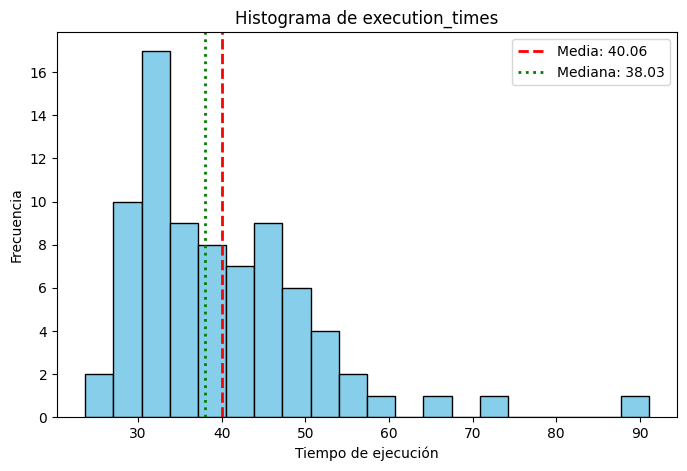

Media: 40.0586
Mediana: 38.0335
Desviación estándar: 10.9397
Intervalo de confianza 95%: (37.5921, 42.5251)
Media: 40.0586
Mediana: 38.0335
Desviación estándar: 10.9397
Intervalo de confianza 95%: 40.0586 ± 2.4665


In [296]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Filtra solo los valores numéricos (floats o ints)
numeric_times = [x for x in execution_times if isinstance(x, (float, int))]

if len(numeric_times) == 0:
    print("No hay tiempos numéricos para analizar.")
else:
    # Calcula media, mediana y desviación estándar
    mean_time = np.mean(numeric_times)
    median_time = np.median(numeric_times)
    std_time = np.std(numeric_times, ddof=1)
    n = len(numeric_times)

    # Intervalo de confianza al 95%
    conf_int = stats.t.interval(
        0.95, df=n-1, loc=mean_time, scale=std_time/np.sqrt(n)
    )

    # Histograma
    plt.figure(figsize=(8,5))
    plt.hist(numeric_times, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(mean_time, color='red', linestyle='dashed', linewidth=2, label=f"Media: {mean_time:.2f}")
    plt.axvline(median_time, color='green', linestyle='dotted', linewidth=2, label=f"Mediana: {median_time:.2f}")
    plt.title("Histograma de execution_times")
    plt.xlabel("Tiempo de ejecución")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

    print(f"Media: {mean_time:.4f}")
    print(f"Mediana: {median_time:.4f}")
    print(f"Desviación estándar: {std_time:.4f}")
    print(f"Intervalo de confianza 95%: ({conf_int[0]:.4f}, {conf_int[1]:.4f})")

    # ... tu código anterior ...

# Calcula el margen de error
margin_of_error = conf_int[1] - mean_time

print(f"Media: {mean_time:.4f}")
print(f"Mediana: {median_time:.4f}")
print(f"Desviación estándar: {std_time:.4f}")
print(f"Intervalo de confianza 95%: {mean_time:.4f} ± {margin_of_error:.4f}")

In [284]:
import os

execution_times = []
problem_data = {}  # Diccionario: key = número de problema, value = {'tiempo': ..., 'py': ...}
base_dir = "nlp4lp_results"

for subdir, dirs, files in os.walk(base_dir):
    for dir in dirs:
        # INSERT_YOUR_CODE
        subdir_path = os.path.join(subdir, dir)
        for file in os.listdir(subdir_path):
            if file == "execution_time.txt":
                file_path = os.path.join(subdir_path, file)
                # Extrae el número de problema del path (asume que el subdirectorio es el número)
                # Ejemplo: nlp4lp_results/23/execution_time.txt
                try:
                    # Busca el número de problema en el path
                    parts = os.path.normpath(file_path).split(os.sep)
                    # Busca el primer elemento numérico en el path después de base_dir
                    prob_num = dir.split("_")[0]

                    # Lee el tiempo de ejecución
                    with open(file_path, "r") as f:
                        content = f.read().strip()
                        content = content.split(" ")[0]
                        try:
                            time_val = float(content)
                        except ValueError:
                            time_val = content
                        execution_times.append(time_val)

                    # Busca el archivo .py en el mismo subdirectorio
                    py_file = None
                    for fname in os.listdir(subdir_path):
                        if fname.endswith(".py"):
                            py_file = os.path.join(subdir_path, fname)
                            break
                    py_text = None
                    if py_file is not None:
                        try:
                            with open(py_file, "r") as fpy:
                                py_text = fpy.read()
                        except Exception as e:
                            print(f"Error leyendo {py_file}: {e}")

                    py_length = len(py_text) if py_text is not None else 0

                except Exception as e:
                    print(f"Error leyendo {file_path}: {e}")
                # Guarda en el diccionario
                problem_data[prob_num] = {
                    "tiempo": time_val,
                    "py": py_text,
                    "char_len": py_length
                }
        
    # Guarda en el diccionario
    problem_data[prob_num] = {
        "tiempo": time_val,
        "py": py_text,
        "char_len": py_length
    }
problem_data


{'234': {'tiempo': 71.674,
  'py': '# Problem Description:\n\'\'\'Problem description: A village delivers mail to nearby villages either by runners or canoers. Runners can carry three bags of mail each time and takes 4 hours. Canoers can carry ten bags of mail each time and takes 2 hours. At most 33% of deliveries can be by canoe. Additionally, the village can spare at most 200 total hours and at least 4 runners must be used. How many of each way to deliver must be used to maximize the total amount of mail that can be delivered?\n\nExpected Output Schema:\n{\n  "variables": {\n    "NumRunnerTrips": "float",\n    "NumCanoeTrips": "float",\n    "NumberOfRunners": "float"\n  },\n  "objective": "float"\n}\'\'\'\n\n# Mathematical Formulation:\n\'\'\'Below is one complete formulation that faithfully translates the problem into a structured five‐element model.\n\n--------------------------------------------------\n\nSets:\n• DeliveryModes = {Runner, Canoe}\n  (This set distinguishes the two t

In [285]:
# INSERT_YOUR_CODE
import matplotlib.pyplot as plt

# Extrae los valores de char_len y tiempo
char_lens = []
tiempos = []
for k, v in problem_data.items():
    # Solo incluye si ambos valores son numéricos
    print("problem:", k)
    try:
        tiempo = float(v["tiempo"])
        char_len = int(v["char_len"])
        char_lens.append(char_len)
        tiempos.append(tiempo)
    except Exception:
        continue


problem: 234
problem: 218
problem: 207
problem: 34
problem: 144
problem: 36
problem: 177
problem: 230
problem: 27
problem: 214
problem: 4
problem: 238
problem: 53
problem: 223
problem: 164
problem: 196
problem: 23
problem: 95
problem: 210
problem: 157
problem: 19
problem: 241
problem: 119
problem: 148
problem: 84
problem: 90
problem: 208
problem: 54
problem: 101
problem: 45
problem: 81
problem: 3
problem: 26
problem: 178
problem: 136
problem: 56
problem: 220
problem: 170
problem: 182
problem: 112
problem: 204
problem: 85
problem: 116
problem: 147
problem: 79
problem: 186
problem: 134
problem: 188
problem: 165
problem: 62
problem: 49
problem: 10
problem: 103
problem: 39
problem: 152
problem: 28
problem: 12
problem: 161
problem: 226
problem: 114
problem: 138
problem: 176
problem: 16
problem: 180
problem: 75
problem: 64
problem: 201
problem: 8
problem: 108
problem: 63
problem: 72
problem: 11
problem: 74
problem: 209
problem: 151
problem: 99
problem: 100
problem: 67


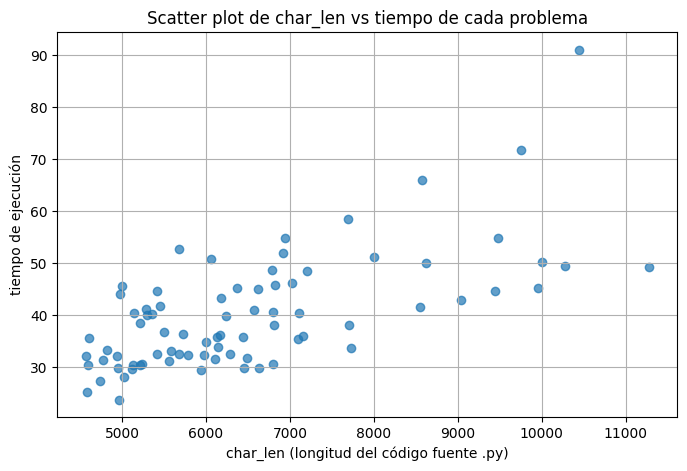

In [286]:

plt.figure(figsize=(8,5))
plt.scatter(char_lens, tiempos, alpha=0.7)
plt.xlabel("char_len (longitud del código fuente .py)")
plt.ylabel("tiempo de ejecución")
plt.title("Scatter plot de char_len vs tiempo de cada problema")
plt.grid(True)
plt.show()

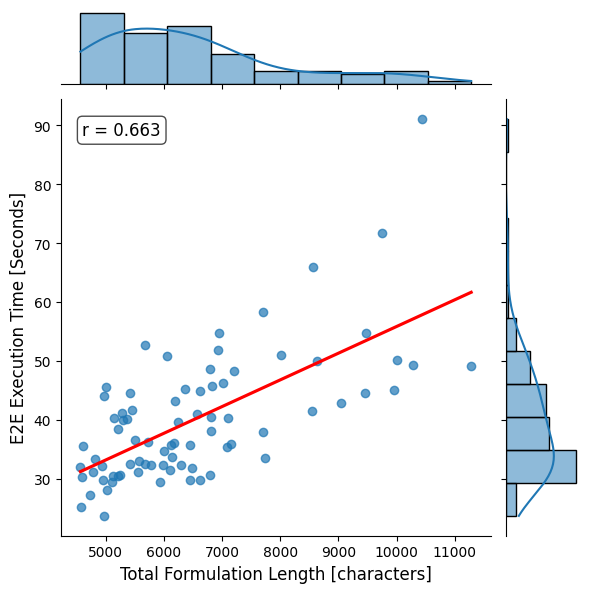

In [297]:
from scipy.stats import linregress
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'char_len': char_lens, 'tiempo': tiempos})

# Calcula el coeficiente de correlación r
slope, intercept, r_value, p_value, std_err = linregress(df['char_len'], df['tiempo'])

# Dibuja el jointplot sin banda de confianza
g = sns.jointplot(
    data=df,
    x='char_len',
    y='tiempo',
    kind='reg',
    height=6,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.7},
    ci=None  # Quita la banda de confianza
)

# Cambia los labels de los ejes
g.set_axis_labels("Total Formulation Length [characters]", "E2E Execution Time [Seconds]", fontsize=12)

# Agrega el valor de r en el gráfico principal
plt.sca(g.ax_joint)
plt.text(
    0.05, 0.95,
    f"r = {r_value:.3f}",
    transform=g.ax_joint.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)
plt.show()